In [1]:
# !pip install tensorflow_text
# !pip install transformers
# !pip install keras-tuner
# !pip install pydot

In [2]:
## Usual Imports

## Math and Arrays
import numpy as np
# import pandas as pd
from statistics import mean

# OS and Utilities
import sys
import datetime

## File and String Handling
import re
import json
import string

# Visualizations
import matplotlib.pyplot as plt

# BERT
from transformers import *
from transformers import BertTokenizer, TFBertModel, BertConfig

# Tensorflow 2 core - preprocessing no longer needed as we are using BERT
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from tensorflow import keras

#Import Tuining toolkit for automatic Hyperparameter search
import kerastuner as kt

# from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
# from tensorflow.keras.preprocessing.sequence import pad_sequences

# Add local path to .py modules and add utilities
sys.path.insert(0, '../python')

import debug

from jbyrne_utils import load_data
# from jbyrne_utils import tokenize_sentences
# from jbyrne_utils import embed_matrix
# from jbyrne_utils import run_model

# Set message level

# debug.off()
# debug.on()
debug.show_detail()


*************** DEBUG DETAILS TURNED ON *****************


In [3]:
### Parameters for the base model

# maximum number of tokens to look at.
max_len = 100



## Step 1:  Load the ClaimBuster datafile

In [4]:
d = load_data("../data/3xNCS.json")

# Randomize the order as the data is sorted by class
np.random.seed(42)
np.random.shuffle(d)


Loaded 11056 data records.


In [5]:
## View an random example entry
d[512]

{'sentence_id': 9703,
 'label': 1,
 'text': 'President Obama was right, he said that that was outrageous to have deficits as high as half a trillion dollars under the Bush years.'}

## Step 2:  Tokenize the sentences using BERT tokenizer



In [6]:
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

In [7]:
input_sentences=[]
input_ids=[]
attention_masks=[]  # used so BERT can discount padding in the fixed-length token list

# avoid big output for just this cell
debug.on()

for sentence in [ i["text"] for i in d ]:
    input_sentences.append(sentence)
    bert_input = bert_tokenizer.encode_plus(sentence,
                                            add_special_tokens=True,  # adds the CLS etc.
                                            max_length=max_len,
                                            truncation=True,          # truncate sentences over max_len
                                            padding = 'max_length',   # add padding ids (0) up to max_len
                                            return_attention_mask=True)
    input_ids.append(bert_input['input_ids'])
    attention_masks.append(bert_input['attention_mask'])
    debug.detail(bert_input)

    
input_ids = np.asarray(input_ids)
attention_masks = np.asarray(attention_masks)
input_sentences = np.asarray(input_sentences)
labels = np.array( [i["label"] for i in d] )

# check lengths of arrays
debug.msg(len(input_ids), len(attention_masks), len(labels), len(input_sentences))

# reset to previous debugging level
debug.last()

****************** DEBUG TURNED ON **********************
11056 11056 11056 11056
*************** DEBUG DETAILS TURNED ON *****************


In [8]:
## Verify the tokenization of the previous sample sentence

debug.msg(d[512]["text"])
debug.msg(input_ids[512])
bert_tokenizer.convert_ids_to_tokens(input_ids[512])



President Obama was right, he said that that was outrageous to have deficits as high as half a trillion dollars under the Bush years.
[  101  2343  8112  2001  2157  1010  2002  2056  2008  2008  2001 25506
  2000  2031 15074  2015  2004  2152  2004  2431  1037 23458  6363  2104
  1996  5747  2086  1012   102     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0]


['[CLS]',
 'president',
 'obama',
 'was',
 'right',
 ',',
 'he',
 'said',
 'that',
 'that',
 'was',
 'outrageous',
 'to',
 'have',
 'deficit',
 '##s',
 'as',
 'high',
 'as',
 'half',
 'a',
 'trillion',
 'dollars',
 'under',
 'the',
 'bush',
 'years',
 '.',
 '[SEP]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]']

## Step 3a: Split into training, validation and test datasets

In [9]:
train_len = int(0.8 * len(d))
val_len = int(0.2 * len(d))

train_ids, val_ids             = np.split(input_ids, [train_len])
train_attn, val_attn           = np.split(attention_masks, [train_len])
train_sentences, val_sentences = np.split(input_sentences, [train_len])
train_labels, val_labels       = np.split(labels, [train_len])

debug.msg(f"proportion of checkable claims in training data  : {np.count_nonzero(train_labels == 1)/len(train_labels):.4f}")
debug.msg(f"proportion of checkable claims in validation data: {np.count_nonzero(val_labels == 1)/len(val_labels):.4f}")

debug.detail(len(train_ids), len(train_attn), len(train_sentences), len(train_labels))
debug.detail(len(val_ids), len(val_attn), len(val_sentences), len(val_labels))

proportion of checkable claims in training data  : 0.2495
proportion of checkable claims in validation data: 0.2518
8844 8844 8844 8844
2212 2212 2212 2212


## Step 3b: Even out the checkable and non-checkable classes.

The intention here is to equalize the number of checkable and non-checkable sentences in the training dataset. In the raw dataset, approximately 25% of the statements are labelled as checkable claims.

As we are looking at detailed text and whether it includes a checkable claim, there is no reliable equivalent of the data enhancement techniques that exist for image or sound data.  

We are presented with the choice, therefore, of removing $\frac{2}{3}$ of the non-checkable claims - as the source dataset has provided, or adding two copies of each checkable claim to reach approximately a 1:1 ratio of classes in the training data. The second method has proved especially successful in the CNN examples, so we will do the same for the BERT case.


In [10]:
## Ideally we could rerandomize the training set, but
## for the moment, we will try just adding copies of 
## the positive records to the end.

pos_train_ids = train_ids[ train_labels == 1 ]
pos_train_attn = train_attn[ train_labels == 1 ]
pos_train_sentences = train_sentences[ train_labels == 1 ]
pos_train_labels = train_labels[ train_labels == 1 ]  # kinda redundant, but an easy way to get the right length.

print(train_ids.shape)
print(train_attn.shape)
print(train_sentences.shape)
print(train_labels.shape)


## concatenate two copies of the positive cases to each of the training datasets

train_ids       = np.concatenate( (train_ids, pos_train_ids, pos_train_ids) )
train_attn      = np.concatenate( (train_attn, pos_train_attn, pos_train_attn) )
train_sentences = np.concatenate( (train_sentences, pos_train_sentences, pos_train_sentences) )
train_labels    = np.concatenate( (train_labels, pos_train_labels, pos_train_labels) )

(8844, 100)
(8844, 100)
(8844,)
(8844,)


In [11]:
print(f"train_ids.shape:       {train_ids.shape}")
print(f"train_attn.shape:      {train_attn.shape}")
print(f"train_sentences.shape: {train_sentences.shape}")
print(f"train_labels.shape:    {train_labels.shape}\n\n")

print(f"val_ids.shape:         {val_ids.shape}")
print(f"val_attn.shape:        {val_attn.shape}")
print(f"val_sentences.shape:   {val_sentences.shape}")
print(f"val_labels.shape:      {val_labels.shape}")

train_ids.shape:       (13258, 100)
train_attn.shape:      (13258, 100)
train_sentences.shape: (13258,)
train_labels.shape:    (13258,)


val_ids.shape:         (2212, 100)
val_attn.shape:        (2212, 100)
val_sentences.shape:   (2212,)
val_labels.shape:      (2212,)


## Step 4: Set up the Bert model

Claim detection is a sentence classification task, so for the first runs, I will base this on the `TFBertForSequenceClassification` class from the huggungface Tensorflow implementation of Bert. 

To keep it simple, the model build is packaged into a build_bert_model function that returns a compiled model
with the search space already added.



In [12]:
# Experiment on building the model



################################################
####  DEFINE THE HYPERPARAMETER SEARCH SPACE ###
################################################
bert_trainable = True

optimizer      = keras.optimizers.Adam( learning_rate = 5e-06, epsilon = 5e-05 )                                            
loss           = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric         = keras.metrics.SparseCategoricalAccuracy('accuracy')

In [13]:
#################################
####  CREATE THE CUSTOM MODEL ###
#################################

# create the bert model using the uncased base (smaller) model
bert_model = TFBertModel.from_pretrained('bert-base-uncased', trainable=bert_trainable, output_hidden_states=False)

# Define the input layer: the tokens are denoted by an integer ID. Max number of tokens = max_len
# The attention mask is similarly an array of max_len integers, but will be only 1 or 0.
# the input layer concatenates the IDs with the attention_masks, the idea is for Bert to ignore
# the padding in the input by using the attention_masks.

input_ids       = keras.Input( shape=(max_len, ), dtype='int32', name="InputIds")
attention_masks = keras.Input( shape=(max_len, ), dtype='int32', name="AttnMasks")



Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [14]:
# output = output[0]
# output = keras.layers.Flatten()(output)

In [15]:
# connect the inputs to the bert model
# output = bert_model([input_ids,attention_masks])

# connect the dense layers we want to add to the output of the
# bert model


output = bert_model([input_ids,attention_masks])

debug.detail(f"output[0] output: {output[0].shape}")
debug.detail(f"output[1] output: {output[1].shape}")


print("Last Hidden Layer Shape:",output.last_hidden_state.shape)

output = output.pooler_output

print("output shape:", output.shape)

output = keras.layers.Dense(1, activation='softmax')(output)
debug.detail(f"dense output: {output.shape}")

model = tf.keras.models.Model(inputs = [input_ids,attention_masks],outputs = output)

print('\nBert Model',model.summary())

############################################
####  COMPILE THE MODEL WITH THE CHOICES ###
############################################
bert_model.compile(loss=loss, optimizer=optimizer, metrics=[metric] )

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
output[0] output: (None, 100, 768)
output[1] output: (None, 768)
Last Hidden Layer Shape: (None, 100, 768)
output shape: (None, 768)
dense output: (None, 1)
Model: "model"
______________________________________________________________________________________

In [16]:
output

<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'dense')>

In [17]:
print(f"train_ids.shape:       {train_ids.shape}")
print(f"train_attn.shape:      {train_attn.shape}")
print(f"train_sentences.shape: {train_sentences.shape}")
print(f"train_labels.shape:    {train_labels.shape}\n\n")

print(f"val_ids.shape:         {val_ids.shape}")
print(f"val_attn.shape:        {val_attn.shape}")
print(f"val_sentences.shape:   {val_sentences.shape}")
print(f"val_labels.shape:      {val_labels.shape}\n\n")

print(f"output.shape:          {output.shape}")

train_ids.shape:       (13258, 100)
train_attn.shape:      (13258, 100)
train_sentences.shape: (13258,)
train_labels.shape:    (13258,)


val_ids.shape:         (2212, 100)
val_attn.shape:        (2212, 100)
val_sentences.shape:   (2212,)
val_labels.shape:      (2212,)


output.shape:          (None, 1)


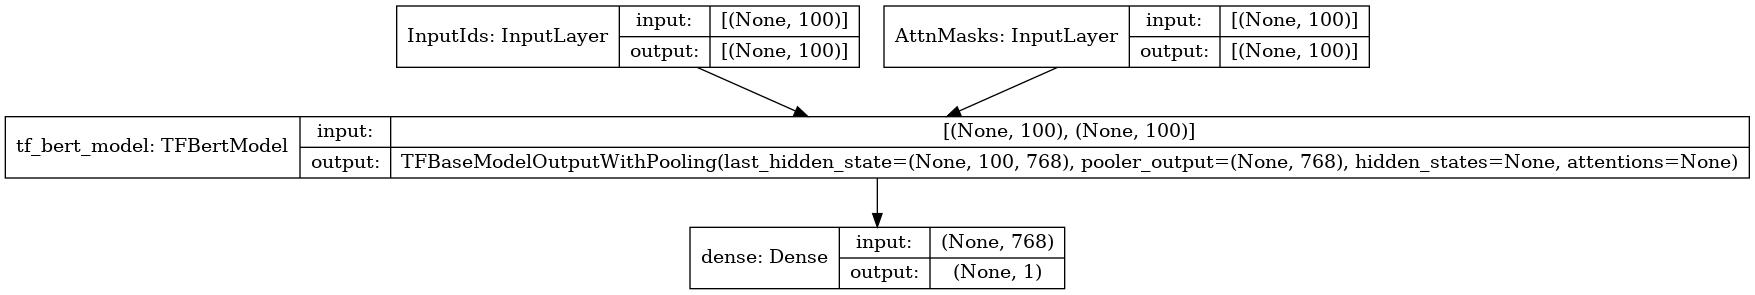

In [18]:
keras.utils.plot_model(model, 'my_model.png', show_shapes=True)

In [19]:
bert_model.predict([train_ids[512], train_attn[512]]).pooler_output[0]

array([-0.7385148 ,  0.12396187,  0.5953804 ,  0.74602216, -0.07064644,
       -0.25380328,  0.65312356,  0.04996727,  0.45983976, -0.95372874,
        0.37731642, -0.42118374,  0.94422495, -0.41625714,  0.76583576,
       -0.43511665, -0.23573057, -0.22394249,  0.36595422, -0.6368858 ,
        0.80603856,  0.36263597,  0.30116037,  0.1930374 ,  0.2150501 ,
       -0.43241334, -0.01000404,  0.9327952 ,  0.8160389 ,  0.717983  ,
       -0.7443686 ,  0.01150791, -0.97709435, -0.10958643,  0.3629195 ,
       -0.8893223 ,  0.12379831, -0.57296044, -0.22069295,  0.03747926,
       -0.9312473 ,  0.11401065,  0.9209239 , -0.28136137,  0.7227345 ,
       -0.16429384, -0.941496  ,  0.10542376, -0.7863832 , -0.7957229 ,
       -0.6958707 , -0.6874954 ,  0.00347094,  0.01238799,  0.00227841,
        0.03181317, -0.0443679 ,  0.15157127, -0.0124316 , -0.28051916,
       -0.00554982,  0.2506614 ,  0.04003055, -0.7517741 , -0.68957484,
       -0.39896083, -0.24633084, -0.28706786,  0.01178957, -0.12

In [27]:
for i in range(len(val_ids)):
    print(f"i = {i}, Sentence: {train_sentences[i]}")
    print(f"label: {val_labels[i]},  prediction: {bert_model.predict([val_ids[i], val_attn[i]]).pooler_output[0][0]}")
    

i = 0, Sentence: The average senior citizen is spending a higher percentage of income on health care today than they were in 1965, before Medicare came in.
label: 0,  prediction: -0.7377869486808777
i = 1, Sentence: people get so tired of politics.
label: 0,  prediction: -0.7377869486808777
i = 2, Sentence: Think of your dreams as a child and ask yourself, isn't it time to stop talking about it?
label: 0,  prediction: -0.7377869486808777
i = 3, Sentence: And if we don't, we will be spending our children's money.
label: 1,  prediction: -0.7377869486808777
i = 4, Sentence: I think you have to look at it.
label: 0,  prediction: -0.7377869486808777
i = 5, Sentence: And whether this House and Senate, in the next session is Democratic or Republican, if the country will have voted for the candidate for the presidency and for the proposals that he has made, I believe that you will find that the president, if it were a Republican, as it would be in my case, would be able to get his program thro

label: 0,  prediction: -0.7377869486808777
i = 51, Sentence: 2nd thing, there are not many times in your life when you get to talk to a whole country.
label: 1,  prediction: -0.7377869486808777
i = 52, Sentence: I committed that I would rein in the excesses of Wall Street, and we passed the toughest Wall Street reforms since the 1930s.
label: 0,  prediction: -0.7377869486808777
i = 53, Sentence: I see people in my state, middle class people -- their taxes have gone up in Washington and their services have gone down while the wealthy have gotten tax cuts.
label: 1,  prediction: -0.7377869486808777
i = 54, Sentence: That is a very serious charge against the president.
label: 0,  prediction: -0.7377869486808777
i = 55, Sentence: It doesn't uh - make a determination as to how uh - that relationship should be achieved in relationship to our current uhh - diplomatic recognition and obligations to the Taiwanese Government.
label: 1,  prediction: -0.7377869486808777
i = 56, Sentence: Governor 

label: 0,  prediction: -0.7377869486808777
i = 105, Sentence: And that's because we structured the plan so that six million additional American families pay no taxes.
label: 0,  prediction: -0.7377869486808777
i = 106, Sentence: I think they will, and I think we'll get there.
label: 1,  prediction: -0.7377869486808777
i = 107, Sentence: We have to remember, when we talk a tax cut, we're only talking about reducing a tax increase, because this Administration has left us with a built-in tax increase that will amount to $86 billion next year.
label: 0,  prediction: -0.7377869486808777
i = 108, Sentence: And that's why I want to get the deficit down by controlling the growth of mandatory spending.
label: 1,  prediction: -0.7377869486808777
i = 109, Sentence: So I rolled the dice, I put my career on the line because I really believe the future of America is on the line.
label: 1,  prediction: -0.7377869486808777
i = 110, Sentence: And he stands here and says politicians who make promises li

label: 0,  prediction: -0.7377869486808777
i = 158, Sentence: There are some who allege, I can't prove it true or untrue, that uh - such a statement uh - in effect invited the North Koreans to invade South Korea.
label: 0,  prediction: -0.7377869486808777
i = 159, Sentence: Every day is earth day if you own the land.
label: 0,  prediction: -0.7377869486808777
i = 160, Sentence: I wanted to turn this country around with a program of opportunity for all, responsibility from all, and an American community where everybody has a role to play.
label: 0,  prediction: -0.7377869486808777
i = 161, Sentence: I owe the special interests nothing.
label: 1,  prediction: -0.7377869486808777
i = 162, Sentence: But the federal government also can play a very important role.
label: 1,  prediction: -0.7377869486808777
i = 163, Sentence: I have been a strong force for reform.
label: 0,  prediction: -0.7377869486808777
i = 164, Sentence: We have learned that you give him an inch he'll take a mile.
label: 

label: 1,  prediction: -0.7377869486808777
i = 215, Sentence: We owe $20 trillion, and we're a mess.
label: 0,  prediction: -0.7377869486808777
i = 216, Sentence: I read his statement the other day.
label: 1,  prediction: -0.7377869486808777
i = 217, Sentence: The Republican party has produced McKinley and Harding, Coolidge, Dewey, and Landon.
label: 0,  prediction: -0.7377869486808777
i = 218, Sentence: And it seems to me that this could be an adjunct, or certainly a great assisting agent in getting that done.
label: 0,  prediction: -0.7377869486808777
i = 219, Sentence: And the number of small businesses I've gone to that are saying they're dropping insurance because they can't afford it, the cost of health care is just prohibitive.
label: 1,  prediction: -0.7377869486808777
i = 220, Sentence: It failed to came to the floor of the House of Representatives.
label: 1,  prediction: -0.7377869486808777
i = 221, Sentence: And yet he condemns the vetoes that I have made that has - that hav

label: 0,  prediction: -0.7377869486808777
i = 266, Sentence: And there is nothing wrong with us having a vigorous debate like we're having tonight about health care, about energy policy, about tax policy.
label: 0,  prediction: -0.7377869486808777
i = 267, Sentence: I know there are all kinds of circumstances and explanations.
label: 0,  prediction: -0.7377869486808777
i = 268, Sentence: Now, to go back to your question, Nikki, we're not getting the best cooperation in the world today.
label: 0,  prediction: -0.7377869486808777
i = 269, Sentence: Let me tell you where the biggest discrimination comes.
label: 0,  prediction: -0.7377869486808777
i = 270, Sentence: Now, ladies and gentlemen, important to understand, the president and his friends try to make a big deal out of it.
label: 0,  prediction: -0.7377869486808777
i = 271, Sentence: We hadn't caught bin Laden.
label: 0,  prediction: -0.7377869486808777
i = 272, Sentence: But the best thing we can do now, Bob, given the circumstanc

label: 0,  prediction: -0.7377869486808777
i = 320, Sentence: They're always very loyal to us, and I appreciate that.
label: 1,  prediction: -0.7377869486808777
i = 321, Sentence: The Mideast is very difficult.
label: 0,  prediction: -0.7377869486808777
i = 322, Sentence: Colin Powell will be on somebody's ticket 4 years from now -- right?
label: 0,  prediction: -0.7377869486808777
i = 323, Sentence: Some of it was excised, but the part dealing with political terrorism was continued.
label: 0,  prediction: -0.7377869486808777
i = 324, Sentence: And if you really look, it's not a tax -- it's really not a great thing for the wealthy.
label: 0,  prediction: -0.7377869486808777
i = 325, Sentence: We should be playing the leadership role there, not on the ground with military.
label: 1,  prediction: -0.7377869486808777
i = 326, Sentence: I thought the best example of a way to handle the situation was East Timor when we provided logistical support to the Australians, support that only we can

label: 1,  prediction: -0.7377869486808777
i = 374, Sentence: And every defense expert I know, including people in the Pentagon itself, will tell you that given the level of defense spending and the level of defense appropriations which the Congress has now approved and the president has signed, there's no way that you can do all of these things and do them well.
label: 0,  prediction: -0.7377869486808777
i = 375, Sentence: I do, because I think that that is the kind of investment where the federal government can help.
label: 0,  prediction: -0.7377869486808777
i = 376, Sentence: Well, first of all, it's great to be with you, and thank you, everybody.
label: 0,  prediction: -0.7377869486808777
i = 377, Sentence: It used to be the United States of America.
label: 0,  prediction: -0.7377869486808777
i = 378, Sentence: Now the reason they don't have, The reason the President can't support this is pretty obvious.
label: 0,  prediction: -0.7377869486808777
i = 379, Sentence: I know how to d

label: 0,  prediction: -0.7377869486808777
i = 425, Sentence: There is nobody who can pose a threat to us there.
label: 0,  prediction: -0.7377869486808777
i = 426, Sentence: Well, Chris, let me respond to that, because that's horrifying.
label: 1,  prediction: -0.7377869486808777
i = 427, Sentence: And Secretary Acheson made a very famous speech at the Press Club, early in the year that k- Korean War started, indicating in effect that South Korea was beyond the defense zone of the United States.
label: 0,  prediction: -0.7377869486808777
i = 428, Sentence: But let me tell you specifically what my plan does.
label: 0,  prediction: -0.7377869486808777
i = 429, Sentence: And it seemed to me if you want to send a signal, you've got to send a signal, Mr. President.
label: 0,  prediction: -0.7377869486808777
i = 430, Sentence: If they weren't willing to work a deal, then we could have put sanctions together.
label: 0,  prediction: -0.7377869486808777
i = 431, Sentence: Nineteen fifty-three 

label: 0,  prediction: -0.7377869486808777
i = 482, Sentence: But among those you named, I won't actively work for the passage of any of them.
label: 0,  prediction: -0.7377869486808777
i = 483, Sentence: You know, when Senator Obama ended up his conversation with Joe the plumber -- we need to spread the wealth around.
label: 0,  prediction: -0.7377869486808777
i = 484, Sentence: The Senate Budget Committee --
label: 0,  prediction: -0.7377869486808777
i = 485, Sentence: And I'll bring that pipeline in from Canada.
label: 0,  prediction: -0.7377869486808777
i = 486, Sentence: Are you for what the Supreme Court says is a constitutional way of having affirmative action?
label: 1,  prediction: -0.7377869486808777
i = 487, Sentence: We simply cannot ignore the fact that, in those cities today, we have 55% youth unemployment among black and Hispanic youth.
label: 0,  prediction: -0.7377869486808777
i = 488, Sentence: Russia is a country in transition.
label: 1,  prediction: -0.7377869486808

label: 0,  prediction: -0.7377869486808777
i = 536, Sentence: And that is to get the support of the people.
label: 0,  prediction: -0.7377869486808777
i = 537, Sentence: It's not good for the country and it's not right.
label: 0,  prediction: -0.7377869486808777
i = 538, Sentence: And I don't intend ever to express regrets to Mr. Khrushchev or anybody else if I'm doing something that has the support of the Congress and that is right for the purpose of protecting the security of the United States.
label: 0,  prediction: -0.7377869486808777
i = 539, Sentence: When I was in a rope line just the other day, coming out here from Wisconsin, a couple of young returnees were in the line, one active duty, one from the Guard.
label: 0,  prediction: -0.7377869486808777
i = 540, Sentence: What I'm saying is that I will tell you at the time.
label: 0,  prediction: -0.7377869486808777
i = 541, Sentence: And we ought to be prepared to provide those funds.
label: 0,  prediction: -0.7377869486808777
i =

label: 0,  prediction: -0.7377869486808777
i = 587, Sentence: I think we just have to continue to work on this until those who think it isn't dangerous and won't kill them and won't destroy their lives, get the message and change.
label: 0,  prediction: -0.7377869486808777
i = 588, Sentence: I would like to, of course, and I presume this administration would as well.
label: 0,  prediction: -0.7377869486808777
i = 589, Sentence: We have been discouraged and we've been alienated.
label: 0,  prediction: -0.7377869486808777
i = 590, Sentence: I congratulate him on -- on taking out Osama bin Laden and going after the leadership in al-Qaeda.
label: 0,  prediction: -0.7377869486808777
i = 591, Sentence: They fought and won World War II.
label: 0,  prediction: -0.7377869486808777
i = 592, Sentence: It's time to have a leader that doesn't put off tomorrow what we should do today.
label: 0,  prediction: -0.7377869486808777
i = 593, Sentence: We love you, and we're grateful to you for everything 

label: 1,  prediction: -0.7377869486808777
i = 638, Sentence: But the leaders that we wanted to get are all gone because they're smart.
label: 0,  prediction: -0.7377869486808777
i = 639, Sentence: And let me add the word safety; it must be done with the utmost of safety.
label: 0,  prediction: -0.7377869486808777
i = 640, Sentence: And just inevitably, they're going to be reluctant to hire Hispanics or people with a different accent.
label: 1,  prediction: -0.7377869486808777
i = 641, Sentence: And I'm very very proud of that choice.
label: 1,  prediction: -0.7377869486808777
i = 642, Sentence: It's important for NATO to be strong and confident and to help keep the peace in Europe.
label: 1,  prediction: -0.7377869486808777
i = 643, Sentence: But I do point out that he's been wrong on many foreign policy and national security issues, which is supposed to be his strength.
label: 1,  prediction: -0.7377869486808777
i = 644, Sentence: Now we have a majority and we get a president.
label:

label: 0,  prediction: -0.7377869486808777
i = 692, Sentence: She has been outsmarted and outplayed worse than anybody I've ever seen in any government whatsoever.
label: 0,  prediction: -0.7377869486808777
i = 693, Sentence: It's going to help those families, and it's going to create incentives to start growing jobs again in this country.
label: 1,  prediction: -0.7377869486808777
i = 694, Sentence: It's so heavy they'd give you a broken back.
label: 0,  prediction: -0.7377869486808777
i = 695, Sentence: Those are the people who ought to be in jail.
label: 0,  prediction: -0.7377869486808777
i = 696, Sentence: We tried to overturn it in the Senate.
label: 1,  prediction: -0.7377869486808777
i = 697, Sentence: You know, Moammar Gadhafi had more American blood on his hands than any individual other than Osama bin Laden.
label: 0,  prediction: -0.7377869486808777
i = 698, Sentence: I think parents will be more involved with education when they know their children's classrooms are safe an

label: 1,  prediction: -0.7377869486808777
i = 746, Sentence: A woman came to me and she said, look, I can't afford insurance for myself or my son.
label: 1,  prediction: -0.7377869486808777
i = 747, Sentence: I supported a big increase in the safe and drug-free schools program.
label: 0,  prediction: -0.7377869486808777
i = 748, Sentence: Uh - what we're doing is saying that there are opportunities, business opportunities, educational opportunities, responsibilities uh - where people with talent, black or any other minority, can fully qualify.
label: 0,  prediction: -0.7377869486808777
i = 749, Sentence: And sometimes you win, sometimes you lose.
label: 0,  prediction: -0.7377869486808777
i = 750, Sentence: They make $51,000 combined income, they pay about $3500 in taxes.
label: 0,  prediction: -0.7377869486808777
i = 751, Sentence: It's our vision of America.
label: 0,  prediction: -0.7377869486808777
i = 752, Sentence: We go back to Washington and very difficult to get it through th

label: 1,  prediction: -0.7377869486808777
i = 797, Sentence: That's not bad for a guy that's never been there, right?
label: 0,  prediction: -0.7377869486808777
i = 798, Sentence: And I'm not the one that compared the President of the United States rotting from like a dead fish from the head down.
label: 0,  prediction: -0.7377869486808777
i = 799, Sentence: However, I honor the right of people who seek the constitutional amendments on school busing, on uh - prayer in the schools and an abortion.
label: 0,  prediction: -0.7377869486808777
i = 800, Sentence: So you really owe him an apology.
label: 0,  prediction: -0.7377869486808777
i = 801, Sentence: The whole premise behind Senator Obama's plans are class warfare, let's spread the wealth around.
label: 0,  prediction: -0.7377869486808777
i = 802, Sentence: But I think it's important to understand, we're not going to solve Social Security and Medicare unless we understand the rest of our tax policies.
label: 0,  prediction: -0.737786

label: 0,  prediction: -0.7377869486808777
i = 854, Sentence: Words matter when you run for president.
label: 1,  prediction: -0.7377869486808777
i = 855, Sentence: Again, you can look it up.
label: 0,  prediction: -0.7377869486808777
i = 856, Sentence: People like Donald, who paid zero in taxes, zero for our vets, zero for our military, zero for health and education, that is wrong.
label: 0,  prediction: -0.7377869486808777
i = 857, Sentence: And let's create jobs and let's get our economy going again.
label: 1,  prediction: -0.7377869486808777
i = 858, Sentence: For instance, we uh - completely revised our prison system.
label: 0,  prediction: -0.7377869486808777
i = 859, Sentence: Uh the Federal Reserve Board indicated that the supply of money would be held between four to four and a half and seven and seven and a half.
label: 0,  prediction: -0.7377869486808777
i = 860, Sentence: Let her release the e-mails.
label: 1,  prediction: -0.7377869486808777
i = 861, Sentence: Now he's hav

label: 0,  prediction: -0.7377869486808777
i = 911, Sentence: I know what it takes to get this country back, and will work with good Democrats and good Republicans to do that.
label: 0,  prediction: -0.7377869486808777
i = 912, Sentence: I was in Dayton, Ohio, and a woman grabbed my arm and she said, "I've been out of work since May.
label: 1,  prediction: -0.7377869486808777
i = 913, Sentence: The present bureaucratic structure of the - of the Federal Government is a mess.
label: 0,  prediction: -0.7377869486808777
i = 914, Sentence: We've got Guards and Reserves who are doing double duties.
label: 0,  prediction: -0.7377869486808777
i = 915, Sentence: We tend to be reactive.
label: 0,  prediction: -0.7377869486808777
i = 916, Sentence: This has got to be stopped.
label: 1,  prediction: -0.7377869486808777
i = 917, Sentence: Since this campaign began I have had a very rare privilege.
label: 1,  prediction: -0.7377869486808777
i = 918, Sentence: My view is that you can do these program

label: 0,  prediction: -0.7377869486808777
i = 968, Sentence: Our military is assisting in Iraq.
label: 0,  prediction: -0.7377869486808777
i = 969, Sentence: Some of that money ends up in the hands of terrorist organizations.
label: 0,  prediction: -0.7377869486808777
i = 970, Sentence: In Egypt we stood on the side of democracy.
label: 0,  prediction: -0.7377869486808777
i = 971, Sentence: That's totally false for him to stand up here and say that.
label: 0,  prediction: -0.7377869486808777
i = 972, Sentence: And the kind of defense program that Mr. Carter wants will mean a weaker defense and a poor negotiating position.
label: 1,  prediction: -0.7377869486808777
i = 973, Sentence: Well, let's talk about what we need to compete.
label: 0,  prediction: -0.7377869486808777
i = 974, Sentence: Whether or not one makes decisions based on sound principles or whether or not you rely upon polls and focus groups on how to decide what the course of action is.
label: 0,  prediction: -0.73778694

label: 0,  prediction: -0.7377869486808777
i = 1022, Sentence: Let me first answer that question about the 1982 tax cut.
label: 1,  prediction: -0.7377869486808777
i = 1023, Sentence: And we honor all the service that they've provided.
label: 1,  prediction: -0.7377869486808777
i = 1024, Sentence: And they believe it because they know I would not take my eye off of the goal: Osama bin Laden.
label: 0,  prediction: -0.7377869486808777
i = 1025, Sentence: Let's take Mr. Bush for the moment at his word -- he's right, we don't have any evidence at least that our government did tell Saddam Hussein he could have that part of Kuwait.
label: 1,  prediction: -0.7377869486808777
i = 1026, Sentence: It's 10 cents a year cumulative.
label: 0,  prediction: -0.7377869486808777
i = 1027, Sentence: But gosh to tell our kids that before they have babies, they ought to think about getting married to someone, that's a great idea.
label: 1,  prediction: -0.7377869486808777
i = 1028, Sentence: We ought to 

label: 0,  prediction: -0.7377869486808777
i = 1076, Sentence: And you can go look it up, and you can check it out.
label: 1,  prediction: -0.7377869486808777
i = 1077, Sentence: Democrats, Republicans, independents, people across our country.
label: 1,  prediction: -0.7377869486808777
i = 1078, Sentence: I met Grant Milliron, Mansfield, Ohio.
label: 1,  prediction: -0.7377869486808777
i = 1079, Sentence: And Hillary Clinton wants to allow a 550 percent increase over Obama.
label: 0,  prediction: -0.7377869486808777
i = 1080, Sentence: With the Arab Spring, came a great deal of hope that there would be a change towards more moderation, and opportunity for greater participation on the part of women in public life, and in economic life in the Middle East.
label: 0,  prediction: -0.7377869486808777
i = 1081, Sentence: And so we have to understand that we can't just surrender and lose jobs year in and year out.
label: 0,  prediction: -0.7377869486808777
i = 1082, Sentence: And, 5, I would 

label: 1,  prediction: -0.7377869486808777
i = 1127, Sentence: I think it's in the best interest of the United States, and the world as a whole that the United States negotiate rather than go back to the cold-war relationship with the Soviet Union.
label: 0,  prediction: -0.7377869486808777
i = 1128, Sentence: I applaud them for it, I don't criticize them.
label: 0,  prediction: -0.7377869486808777
i = 1129, Sentence: But if you want change, you need to get somebody that knows how to bring Republicans and Democrats together to get positive things done for America.
label: 0,  prediction: -0.7377869486808777
i = 1130, Sentence: If they do, then they will have heard the harsh reality of what we have to do.
label: 1,  prediction: -0.7377869486808777
i = 1131, Sentence: Many say four and a half per cent.
label: 0,  prediction: -0.7377869486808777
i = 1132, Sentence: Most of the tax cuts went to low- and middle-income Americans.
label: 0,  prediction: -0.7377869486808777
i = 1133, Sentence: 

label: 0,  prediction: -0.7377869486808777
i = 1181, Sentence: I believe that the opposite is true with President Ford's campaign, and uh - I hope that we can leave those issues in this next ten days about personalities and mistakes of the past - we've both made some mistakes - and talk about unemployment, inflation, housing, education, taxation, government organization, stripping away of secrecy, and the things that are crucial to the American people.
label: 0,  prediction: -0.7377869486808777
i = 1182, Sentence: And after that, a number of women have come forward saying that's exactly what he did to them.
label: 0,  prediction: -0.7377869486808777
i = 1183, Sentence: And my opponent has got a plan of retreat and defeat in Iraq.
label: 0,  prediction: -0.7377869486808777
i = 1184, Sentence: My concerns about the senator is that, in the course of this campaign, I've been listening very carefully to what he says, and he changes positions on the war in Iraq.
label: 1,  prediction: -0.737

label: 0,  prediction: -0.7377869486808777
i = 1223, Sentence: Have you noticed, they've been in charge the last two years.
label: 0,  prediction: -0.7377869486808777
i = 1224, Sentence: And I intend to win it as President of the United States.
label: 0,  prediction: -0.7377869486808777
i = 1225, Sentence: I favor higher salaries for teachers.
label: 0,  prediction: -0.7377869486808777
i = 1226, Sentence: That in itself is a big difference.
label: 0,  prediction: -0.7377869486808777
i = 1227, Sentence: They didn't tell you that that same year they increased spending $1.83 for every dollar we increased taxes.
label: 0,  prediction: -0.7377869486808777
i = 1228, Sentence: In the case of the product liability bill, which they passed and I vetoed, I think that's what he's talking about, I actually wanted to sign that bill.
label: 0,  prediction: -0.7377869486808777
i = 1229, Sentence: Our plan is better, it will take us into the future with a growing economy and healthier families.
label: 

label: 0,  prediction: -0.7377869486808777
i = 1277, Sentence: He is so good with these computers, it's unbelievable.
label: 0,  prediction: -0.7377869486808777
i = 1278, Sentence: And so I'll just be asking for support to get that put into effect.
label: 0,  prediction: -0.7377869486808777
i = 1279, Sentence: She won't say the name and President Obama won't say the name.
label: 0,  prediction: -0.7377869486808777
i = 1280, Sentence: The Kurds have been our best partners in Syria, as well as Iraq.
label: 0,  prediction: -0.7377869486808777
i = 1281, Sentence: Well, first of all those are reports in the newspaper.
label: 0,  prediction: -0.7377869486808777
i = 1282, Sentence: Secretary, you have no plan.
label: 1,  prediction: -0.7377869486808777
i = 1283, Sentence: Now why were we successful, as our predecessors were not successful?
label: 0,  prediction: -0.7377869486808777
i = 1284, Sentence: Now, everyone in the world knows that there were no weapons of mass destruction.
label: 0,  

label: 0,  prediction: -0.7377869486808777
i = 1332, Sentence: And -- and that is part of what's at stake in this election.
label: 0,  prediction: -0.7377869486808777
i = 1333, Sentence: Put a head fake on us.
label: 0,  prediction: -0.7377869486808777
i = 1334, Sentence: I think that says a great deal to the American people about the standards we'll set and the quality of the people that we will pick to serve in our Administration.
label: 0,  prediction: -0.7377869486808777
i = 1335, Sentence: But I do know that if the president of the United States and the Congress of the United States and the people of the United States said, "I believe our nation is greater than what we are now."
label: 0,  prediction: -0.7377869486808777
i = 1336, Sentence: If America shows uncertainty or weakness in this decade, the world will drift toward tragedy.
label: 1,  prediction: -0.7377869486808777
i = 1337, Sentence: Instead let people make their own choice.
label: 1,  prediction: -0.7377869486808777
i 

label: 0,  prediction: -0.7377869486808777
i = 1383, Sentence: And if we've got math teachers who are able to provide the kind of support that they need for our kids, that's what's going to determine whether or not the new businesses are created here.
label: 0,  prediction: -0.7377869486808777
i = 1384, Sentence: But uh - if - if you could just do away with the ones that are unfair, you could lower taxes for everyone.
label: 1,  prediction: -0.7377869486808777
i = 1385, Sentence: She doesn't like Putin because Putin has outsmarted her at every step of the way.
label: 0,  prediction: -0.7377869486808777
i = 1386, Sentence: We didn't think that was right.
label: 0,  prediction: -0.7377869486808777
i = 1387, Sentence: Sometimes my advice has been taken.
label: 0,  prediction: -0.7377869486808777
i = 1388, Sentence: The fact is that this nation, in the eight years before I became President, had its own military strength decreased.
label: 0,  prediction: -0.7377869486808777
i = 1389, Senten

label: 0,  prediction: -0.7377869486808777
i = 1437, Sentence: And it shouldn't be allowed to happen.
label: 0,  prediction: -0.7377869486808777
i = 1438, Sentence: I've seen it authoritatively written twice, and if I've done him an injustice, and he didn't say it, I'm very, very sorry.
label: 0,  prediction: -0.7377869486808777
i = 1439, Sentence: We passed this year the most furthest looking transportation bill in the history of this country since Eisenhower started the interstate highways -- $150 billion for improving the infrastructure.
label: 1,  prediction: -0.7377869486808777
i = 1440, Sentence: And it is going to be operating at surpluses and I don't want the liberal Democratic Congress to spend out of that Social Security Trust Fund or go and take the money out for some other purpose.
label: 0,  prediction: -0.7377869486808777
i = 1441, Sentence: It's a difference of opinion.
label: 0,  prediction: -0.7377869486808777
i = 1442, Sentence: I think it would be great if we got alo

label: 0,  prediction: -0.7377869486808777
i = 1494, Sentence: When a factory closes, I know the people who ran it.
label: 0,  prediction: -0.7377869486808777
i = 1495, Sentence: And as I just told you, there's going to be a summit of the Arab nations.
label: 0,  prediction: -0.7377869486808777
i = 1496, Sentence: Now, again this statement that somehow, I wanted to destroy it and I just changed my tune, that I am for voluntary Social Security, which would mean the ruin of it.
label: 0,  prediction: -0.7377869486808777
i = 1497, Sentence: Somebody who sits in Washington, D.C., eighteen months after the Mayaguez incident, can be a very good grandstand quarterback.
label: 0,  prediction: -0.7377869486808777
i = 1498, Sentence: First, we have to build an economy that works for everyone, not just those at the top.
label: 0,  prediction: -0.7377869486808777
i = 1499, Sentence: Well, what he is saying there in effect, we're going to have inflation.
label: 0,  prediction: -0.7377869486808777
i

label: 0,  prediction: -0.7377869486808777
i = 1545, Sentence: I want to provide tax breaks for companies that are investing here in the United States.
label: 0,  prediction: -0.7377869486808777
i = 1546, Sentence: When you have 900 files gathered up by some guy who is a bouncer in a bar and hired a security officer to collect files, in Watergate -- I know a person who went to jail for looking at one file, one FBI file.
label: 0,  prediction: -0.7377869486808777
i = 1547, Sentence: And I'm going to put in place a better homeland security effort.
label: 0,  prediction: -0.7377869486808777
i = 1548, Sentence: And I supported a big expansion in safe and drug-free schools program to support things like the DARE program because I thought all those things were very important.
label: 0,  prediction: -0.7377869486808777
i = 1549, Sentence: The federal government should take no more than a third of anybody's check.
label: 0,  prediction: -0.7377869486808777
i = 1550, Sentence: The money goes 10

label: 0,  prediction: -0.7377869486808777
i = 1599, Sentence: And I think that's the only way that the United States is going to maintain its freedom.
label: 1,  prediction: -0.7377869486808777
i = 1600, Sentence: Here are a couple of differences, though, Jim.
label: 0,  prediction: -0.7377869486808777
i = 1601, Sentence: We have an opportunity working together to build that future, to build a better America, to build a best America, because the best America doesn't hide.
label: 0,  prediction: -0.7377869486808777
i = 1602, Sentence: I was going to say something...
label: 0,  prediction: -0.7377869486808777
i = 1603, Sentence: And in this case, it's not only about Roe v. Wade.
label: 1,  prediction: -0.7377869486808777
i = 1604, Sentence: In the second century of our nation's history, our forefathers developed the most productive industrial nation in the history of the globe.
label: 0,  prediction: -0.7377869486808777
i = 1605, Sentence: The most important thing is, I believe we've go

label: 1,  prediction: -0.7377869486808777
i = 1647, Sentence: Look, we are sending $700 billion a year overseas to countries that don't like us very much.
label: 1,  prediction: -0.7377869486808777
i = 1648, Sentence: Look, this isn't about Governor Bush, it's not about me.
label: 0,  prediction: -0.7377869486808777
i = 1649, Sentence: At the same time, we have to take care of people on all sides.
label: 0,  prediction: -0.7377869486808777
i = 1650, Sentence: That's why we doubled fuel efficiency standards on cars.
label: 1,  prediction: -0.7377869486808777
i = 1651, Sentence: So, research, speeding the drugs to market, testing, blood supply are very important elements of this.
label: 1,  prediction: -0.7377869486808777
i = 1652, Sentence: And so the person you talked to, I say, here's some help, here's some trade adjustment assistance money for you to go a community college in your neighborhood, a community college which is providing the skills necessary to fill the jobs of the 21st 

label: 1,  prediction: -0.7377869486808777
i = 1692, Sentence: We cannot be strong militarily when we're teeter-tottering on top of a mountain of debt which has been created in the past eight years.
label: 1,  prediction: -0.7377869486808777
i = 1693, Sentence: And there would simply be a delay, and on the other hand, many of the people who would then be given jobs are presently wards of the Government and it wouldn't hurt to give them a tax incentive, because they... that wouldn't be costing Government anything either.
label: 0,  prediction: -0.7377869486808777
i = 1694, Sentence: Well, I think the answer to why the drop, I think, has been the economy in the doldrums.
label: 0,  prediction: -0.7377869486808777
i = 1695, Sentence: Do you know we don't have a single program sponsored by our government to Cuba - to tell them our story, to tell them that we are their friends, that we want them to be free again?
label: 0,  prediction: -0.7377869486808777
i = 1696, Sentence: And we spent so

label: 0,  prediction: -0.7377869486808777
i = 1740, Sentence: Let's not let them fool with it anymore.
label: 0,  prediction: -0.7377869486808777
i = 1741, Sentence: If I knew of three new weapons systems that I thought were purely waste and weren't protected by the Congress, they wouldn't be in the budget.
label: 0,  prediction: -0.7377869486808777
i = 1742, Sentence: This is the approach we have to take to get America to a balanced budget.
label: 0,  prediction: -0.7377869486808777
i = 1743, Sentence: The George Bush who was the charter member of the environmental wrecking crew that went to Washington in the early '80s and did a job on the EPA, or the one we've been seeing and listening to the past two or three months.
label: 1,  prediction: -0.7377869486808777
i = 1744, Sentence: We know that the path we're taking is not working.
label: 0,  prediction: -0.7377869486808777
i = 1745, Sentence: Another point I wanna make is this.
label: 1,  prediction: -0.7377869486808777
i = 1746, Se

label: 0,  prediction: -0.7377869486808777
i = 1794, Sentence: I have questioned his proposals.
label: 0,  prediction: -0.7377869486808777
i = 1795, Sentence: Forty-seven million Americans are without health insurance in America today.
label: 1,  prediction: -0.7377869486808777
i = 1796, Sentence: AARP thinks that the -- the savings that we obtained from Medicare bolster the system, lengthen the Medicare trust fund by eight years.
label: 1,  prediction: -0.7377869486808777
i = 1797, Sentence: But there is no corner on this sleaze factor, believe me.
label: 0,  prediction: -0.7377869486808777
i = 1798, Sentence: Values begin at the top, in the White House.
label: 0,  prediction: -0.7377869486808777
i = 1799, Sentence: The fa- the farmer who grows wheat gets about two and a half cents out of a twenty-five-cent loaf of bread.
label: 0,  prediction: -0.7377869486808777
i = 1800, Sentence: The s- I believe the Soviet Union is first in outer space.
label: 0,  prediction: -0.7377869486808777


label: 0,  prediction: -0.7377869486808777
i = 1848, Sentence: And in fact, employers are looking for skilled workers.
label: 1,  prediction: -0.7377869486808777
i = 1849, Sentence: we're confronted with the horrendous problems that we've discussed here tonight.
label: 0,  prediction: -0.7377869486808777
i = 1850, Sentence: And they want it because they've understood from the beginning that when we open doors, we're all stronger, just as we were at the Olympics.
label: 1,  prediction: -0.7377869486808777
i = 1851, Sentence: He's shipped jobs to 12 countries, including Mexico.
label: 0,  prediction: -0.7377869486808777
i = 1852, Sentence: There is no way of anticipating what may happen.
label: 0,  prediction: -0.7377869486808777
i = 1853, Sentence: But we've also got to continue to figure out how we have efficiency energy, because ultimately that's how we're going to reduce demand and that's what's going to keep gas prices lower.
label: 1,  prediction: -0.7377869486808777
i = 1854, Sent

label: 0,  prediction: -0.7377869486808777
i = 1893, Sentence: There were a whole bunch of oil companies.
label: 1,  prediction: -0.7377869486808777
i = 1894, Sentence: I vetoed a number of bills of that kind myself, when I was in California.
label: 1,  prediction: -0.7377869486808777
i = 1895, Sentence: I said before, watch Ukraine.
label: 1,  prediction: -0.7377869486808777
i = 1896, Sentence: You may think the biggest employer in America is General Motors, but I've got news for you.
label: 0,  prediction: -0.7377869486808777
i = 1897, Sentence: The minute we have bilateral talks, the six-party talks will unwind.
label: 0,  prediction: -0.7377869486808777
i = 1898, Sentence: Let me first give you a sports update.
label: 0,  prediction: -0.7377869486808777
i = 1899, Sentence: I think we should stiffen the embargo on the Belgrade government, and I think we have to consider whether or not we should lift the arms embargo now on the Bosnians, since they are in no way in a fair fight with 

label: 0,  prediction: -0.7377869486808777
i = 1947, Sentence: Recently his key economic adviser was asked about why he didn't seem to have some specific programs to help young people go to college and the response was, well, you know, we can't give money to every interest group that comes along.
label: 0,  prediction: -0.7377869486808777
i = 1948, Sentence: If we're going to combat unemployment, then, we have to do a better job in these areas.
label: 0,  prediction: -0.7377869486808777
i = 1949, Sentence: And the fact of the matter is that, when Obamacare is fully implemented, we're going to be in a position to show that costs are going down.
label: 0,  prediction: -0.7377869486808777
i = 1950, Sentence: How -- why would these people stay there?
label: 1,  prediction: -0.7377869486808777
i = 1951, Sentence: I want to change those provisions.
label: 1,  prediction: -0.7377869486808777
i = 1952, Sentence: I think we ought to be lifting them up and moving our children forward.
label: 0, 

label: 0,  prediction: -0.7377869486808777
i = 2001, Sentence: And I don't think that's just the kind of exaggeration that we take pride in as Americans.
label: 0,  prediction: -0.7377869486808777
i = 2002, Sentence: But, you see, my fundamental philosophy is give local and state government as much control as possible.
label: 0,  prediction: -0.7377869486808777
i = 2003, Sentence: We're going to do that with regulatory reform.
label: 0,  prediction: -0.7377869486808777
i = 2004, Sentence: And the greatest resource of all are the two hundred and fifteen million Americans who have within us the strength, the character, the intelligence, the experience, the patriotism, the idealism, the compassion, the sense of brotherhood on which we can rely in the future to restore the greatness to our country We ought not to be excluded from our government anymore.
label: 0,  prediction: -0.7377869486808777
i = 2005, Sentence: I just care whether it works for America and whether it's going to make us 

label: 1,  prediction: -0.7377869486808777
i = 2058, Sentence: That we must, in the failure to be able to protect our national security as it is today, we must not be provocative to any possible adversary.
label: 0,  prediction: -0.7377869486808777
i = 2059, Sentence: I was in Houston on Tuesday meeting with a group of good citizens, working citizens.
label: 1,  prediction: -0.7377869486808777
i = 2060, Sentence: Well, some people look up figures, and some people make up figures.
label: 0,  prediction: -0.7377869486808777
i = 2061, Sentence: Most small businesses -- 70 percent of the new jobs in America are created by small businesses.
label: 0,  prediction: -0.7377869486808777
i = 2062, Sentence: It's important for our future uhh - economic security that that job be nonpolitical and uh - separate from the executive and the Legislative branches.
label: 1,  prediction: -0.7377869486808777
i = 2063, Sentence: And they installed a Marxist-Leninist totalitarian government.
label: 1,  predi

label: 1,  prediction: -0.7377869486808777
i = 2103, Sentence: I want to give every American a $5,000 refundable tax credit.
label: 1,  prediction: -0.7377869486808777
i = 2104, Sentence: Well, I believe that conservation, at course, is worthy in and of itself.
label: 0,  prediction: -0.7377869486808777
i = 2105, Sentence: He decides who the right people are.
label: 0,  prediction: -0.7377869486808777
i = 2106, Sentence: After 9/11, when the 28 nations of NATO said that they would go to Afghanistan with us to fight terrorism, something that they still are doing by our side.
label: 0,  prediction: -0.7377869486808777
i = 2107, Sentence: But that in and of itself was a good thing.
label: 0,  prediction: -0.7377869486808777
i = 2108, Sentence: It leaves a hundred miles between the sea.
label: 0,  prediction: -0.7377869486808777
i = 2109, Sentence: There may be a way of reaching out to the uninsured, because there are a lot of uninsured people in the country, particularly children, that sh

label: 1,  prediction: -0.7377869486808777
i = 2157, Sentence: There's no doubt itÃ¢â‚¬â„¢s gonna affect our budgets.
label: 0,  prediction: -0.7377869486808777
i = 2158, Sentence: And it's a disgrace, and I will do my level best to clean it up, recognizing that you can't legislate morality.
label: 0,  prediction: -0.7377869486808777
i = 2159, Sentence: I cannot believe I'm saying that about myself, but I guess I have been a politician.
label: 0,  prediction: -0.7377869486808777
i = 2160, Sentence: I respect their -- I respect -- on the one hand he says he agrees with me and then he says he doesn't.
label: 0,  prediction: -0.7377869486808777
i = 2161, Sentence: Certainly we care about the people, we care about the children, we care about the tragedy.
label: 0,  prediction: -0.7377869486808777
i = 2162, Sentence: One of his bills that was overridden - he only got one vote in the Senate and seven votes in the House, from Republicans.
label: 0,  prediction: -0.7377869486808777
i = 2163, S

label: 0,  prediction: -0.7377869486808777
i = 2205, Sentence: Well, how about this for a government reform policy?
label: 0,  prediction: -0.7377869486808777
i = 2206, Sentence: We need to say we each need to be responsible for what we do.
label: 0,  prediction: -0.7377869486808777
i = 2207, Sentence: Mine is I want to empower people in their own lives.
label: 1,  prediction: -0.7377869486808777
i = 2208, Sentence: I'm just not going to do that.
label: 0,  prediction: -0.7377869486808777
i = 2209, Sentence: I said in 1992 he didn't extend that courtesy to President Bush.
label: 0,  prediction: -0.7377869486808777
i = 2210, Sentence: But let me just say to America: I am not proposing a government-run program.
label: 0,  prediction: -0.7377869486808777
i = 2211, Sentence: But it takes more than that.
label: 0,  prediction: -0.7377869486808777


In [26]:
history=bert_model.fit([train_ids,train_attn],
                       train_labels,
                       batch_size=32,
                       epochs=4,
                       # validation_data=([val_ids,val_attn],val_labels) 
                      )

Epoch 1/4


InvalidArgumentError:  assertion failed: [Condition x == y did not hold element-wise:] [x (sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/Shape_1:0) = ] [32 1] [y (sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/strided_slice:0) = ] [32 100]
	 [[node sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert (defined at <ipython-input-21-fd24e98614b0>:1) ]] [Op:__inference_train_function_958828]

Function call stack:
train_function


## References used
BERT Text Classification using Keras https://swatimeena989.medium.com/bert-text-classification-using-keras-903671e0207d#2f06

Keras Tuner blog: https://blog.tensorflow.org/2020/01/hyperparameter-tuning-with-keras-tuner.html

Keras Tuner Git:  https://github.com/keras-team/keras-tuner

Huggingface with custom dense layers: https://www.kaggle.com/dhruv1234/huggingface-tfbertmodel

http://jalammar.github.io/illustrated-bert/

@misc{omalley2019kerastuner,
	title        = {Keras {Tuner}},
	author       = {O'Malley, Tom and Bursztein, Elie and Long, James and Chollet, Fran\c{c}ois and Jin, Haifeng and Invernizzi, Luca and others},
	year         = 2019,
	howpublished = {\url{https://github.com/keras-team/keras-tuner}}
}